<a href="https://colab.research.google.com/github/keran-w/Projects-in-ML-and-AI/blob/main/ProjML%26AI_hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 3 -- Deep Learning
https://submitty.cs.rpi.edu/courses/f22/csci4962/course_material/Homeworks/Homework%203.pdf

In [1]:
# connect to google drive
from google.colab import drive
from IPython.display import clear_output
drive.mount('/content/drive', force_remount=True)
clear_output()

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset 
# data source https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17
dataset_path = 'drive/MyDrive/Datasets/star_classification.csv'

In [3]:
# read file using pandas
import numpy as np
import pandas as pd
data = pd.read_csv(dataset_path)
print(data.shape)
data.head(5)

(100000, 18)


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


## Task 1 (10 points):
Assuming you are not familiar with the framework, in this part of the
homework you will present your research describing the resources you used to learn the
framework (must include links to all resources). Clearly explain why you needed a particular
resource for implementing a 2-layer Neural Network (NN). (Consider how you will keep track of
all the computations in a NN i.e., what libraries/tools do you need within this framework.)

Assuming I am not familiar with the framework, I will take a look at an introduction about neural networks and then learn about the tools (linear layer and activation functions) to implement the algorithms. Here are some resources I am learning from:

[1] A Beginner Intro to Neural Networks https://purnasaigudikandula.medium.com/a-beginner-intro-to-neural-networks-543267bda3c8

[2] PyTorch Linear Transformation https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

[3] PyTorch ReLU Activation Function https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html

## Task 2 (60 points): 
Once you have figured the resources you need for the project, design, and
implement your project. The project must include the following steps (it’s not limited to these steps):

 ### Exploratory Data Analysis

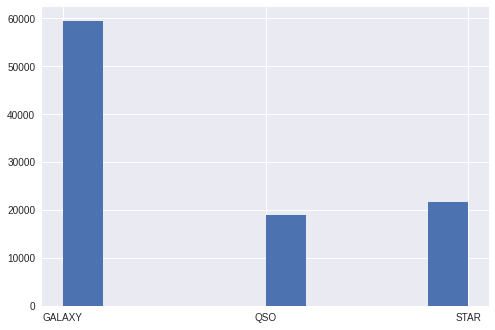

In [4]:
# visualize classification info
import matplotlib.pyplot as plt
plt.style.use('seaborn')
data['class'].hist();

In [5]:
# checking whether the dataset has any empty entries, and shown in the table below, there is none 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [6]:
# data prepreocessing
X = data.copy()
y = X.pop('class')
X, y = X.values, y.values

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
{v:k for k, v in zip(le.classes_, le.fit_transform(le.classes_))}

{0: 'GALAXY', 1: 'QSO', 2: 'STAR'}

### Perform a train-dev-test split

In [7]:
# split train, valid and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.12, random_state=20)
len(X_train), len(X_valid), len(X_test)

(79200, 10800, 10000)

In [8]:
# build custom dataset
import torch
from torch import utils
class dataset(utils.data.Dataset):
    def __init__(self, X, y):
        self.X, self.y = torch.tensor(X), torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            'X': self.X[idx],
            'y': self.y[idx]
        }

def get_loader(X, y, shuffle=False, batch_size=32):
    return utils.data.DataLoader(dataset(X, y), shuffle=shuffle, batch_size=batch_size)

train_loader = get_loader(X_train, y_train, shuffle=True)
valid_loader = get_loader(X_valid, y_valid)
test_loader = get_loader(X_test, y_test)

sample_batch = next(iter(train_loader))
# sample_batch

### Implement Model

I build the model using batch normalization for the input and then a 2-layer deep neural network with a ReLu activation function. For forward propagation, the hyperparameters I am using are the hidden layer's size and a dropout probability.

In [9]:
# create model
from torch import nn
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, device, dropout=0.1):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, hidden_dim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        self.device = device
        self.to(device)
    
    def forward(self, batch):
        X = batch['X'].float().to(device)
        return self.layers(X)

input_dim = X.shape[1]
hidden_dim = 32
output_dim = len(set(y))

model = Model(input_dim, hidden_dim, output_dim, device)
model(sample_batch)[:5]

tensor([[ 0.2067,  0.0268, -0.3004],
        [ 0.0152, -0.2989,  0.1917],
        [ 0.2558, -0.3258, -0.6072],
        [ 0.1581, -0.1777, -0.1476],
        [-0.0503, -0.2100, -0.0878]], grad_fn=<SliceBackward0>)

In [10]:
# Compute the final cost function
criterion = nn.CrossEntropyLoss()
# Implement gradient descent
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [11]:
from tqdm.autonotebook import tqdm
from sklearn import metrics

# compute f1 score for torch tensors
def f1_score(y_true_, y_pred_):
    y_true = y_true_.cpu().numpy()
    y_pred = y_pred_.cpu().numpy()
    return metrics.f1_score(y_true, y_pred, average='weighted')

n_epoch = 10
test_results = []
for epoch in range(n_epoch):
    model.train()
    train_pbar = tqdm(train_loader)
    train_pbar.set_description_str(f'[ Train {epoch+1:03d}/{n_epoch:03d} ]')
    loss_list, acc_list, f1_list = [], [], []
    for batch in train_pbar:
        optimizer.zero_grad()
        logits = model(batch)
        true_labels = batch['y'].long().to(device)
        loss = criterion(logits, true_labels)
        loss.backward()
        optimizer.step()
        train_pbar.set_postfix_str(f'loss: {loss}')
        loss_list.append(loss.item())

    model.eval()
    with torch.no_grad():
        valid_pbar = tqdm(valid_loader)
        valid_pbar.set_description_str(f'[ Valid {epoch+1:03d}/{n_epoch:03d} ]')
        for batch in valid_pbar:
            logits = model(batch).detach()
            true_labels = batch['y'].long().to(device)
            predictions = logits.argmax(1)
            acc = (predictions == true_labels).float().mean().item()
            f1 = f1_score(true_labels, predictions)
            valid_pbar.set_postfix_str(f'acc: {acc}, f1: {f1}')
            acc_list.append(acc)
            f1_list.append(f1)
    print(f'Average train loss: {np.mean(loss_list):.4f} Average test accuracy: {np.mean(acc_list):.3f} Average f1 score: {np.mean(f1_list):.3f}')
    test_results.append([np.mean(acc_list), np.mean(f1_list)])

  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.7349 Average test accuracy: 0.824 Average f1 score: 0.798


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.4293 Average test accuracy: 0.879 Average f1 score: 0.874


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.3460 Average test accuracy: 0.885 Average f1 score: 0.878


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.3152 Average test accuracy: 0.923 Average f1 score: 0.922


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.2985 Average test accuracy: 0.928 Average f1 score: 0.928


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.2895 Average test accuracy: 0.914 Average f1 score: 0.911


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.2809 Average test accuracy: 0.928 Average f1 score: 0.927


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.2747 Average test accuracy: 0.881 Average f1 score: 0.878


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.2714 Average test accuracy: 0.935 Average f1 score: 0.934


  0%|          | 0/2475 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

Average train loss: 0.2679 Average test accuracy: 0.923 Average f1 score: 0.921


### Present the results using the test set

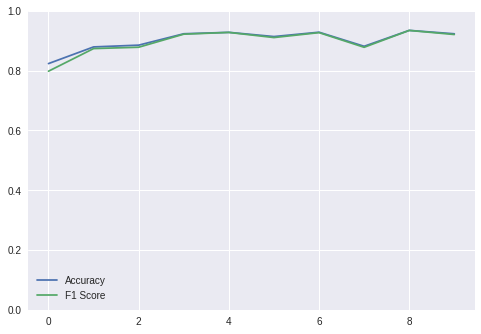

In [12]:
test_results = np.array(test_results)
acc_results = test_results[:, 0]
f1_resutls = test_results[:, 1]
plt.ylim([0,1])
plt.plot(acc_results, label='Accuracy')
plt.plot(f1_resutls, label='F1 Score')
plt.legend()
plt.show()

## Task 3 (10 points): 

In task 2 describe how you selected the hyperparameters. What was the
rationale behind the technique you used? Did you use regularization? Why, or why not? Did you use
an optimization algorithm? Why or why not?

I tune the hyperparameter hidden layer's size for this problem by selecting the hidden size within (8, 16, 32, 64, 128) that the test set has the highest f1 score. I choose the f1 score because the labels are relatively imbalanced.

For regularization, I use batch normalization and dropout to avoid overfitting. I use Adam optimizer for optimization because I only need to tune the learning rate, and it runs fast.

## Task 4 (20 points): 

Create another baseline model (can be any model we covered so far except a
deep learning model). Using the same training data (as above) train your model and evaluate
results using the test set. Compare the results of both models (the Neural Network and the
baseline model). What are the reasons for one model performing better (or not) than the
other? Explain.

In [13]:
# implement random forest classifier
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=20)
clf.fit(X_train, y_train)
print(metrics.classification_report(clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6009
           1       0.93      0.96      0.95      1887
           2       1.00      0.99      0.99      2104

    accuracy                           0.98     10000
   macro avg       0.97      0.98      0.97     10000
weighted avg       0.98      0.98      0.98     10000



As shown in the table above, we observe that the random forest classifier outperforms the 2-layer neural network in terms of both accuracy and f1 score. The former is better because of two reasons.

1. The random forest classifier is an ensemble model that combines many not-so-good models and votes on the classification. At the same time, the 2-layer neural network relies on a single model, which is not very good for this problem.

2. In general, multilayer perceptrons cannot extract classification features as skillfully as tree-based models, especially when the attributes of the data are not independent, which is typical for tabular datasets.